In [1]:
!pip install --upgrade --user scikit-learn

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm

from sklearn.feature_selection import RFE


In [57]:
df = pd.read_csv("customer_booking.csv", encoding_errors="ignore", )

In [58]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [59]:
df.shape

(50000, 14)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

# Exploratory Data Analysis

In [61]:
df.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

In [62]:
def pieplot(df, col, fig_size = (6, 7)):
    value_count = df[col].value_counts()
    values_ = value_count.to_list()
    labels_ = value_count.index.to_list()
    labels_with_value = [f"{label}\n{value}" for label, value in zip(labels_, values_)]
    plt.figure(figsize=fig_size)

    plt.pie(x=values_, labels=labels_with_value, autopct='%1.2f%%', radius=1, startangle=30,
            textprops={'fontsize': 16, "weight": "semibold"})
    plt.title(f"Distribution of {col}", fontsize=20, weight="bold")
    plt.axis('equal')

In [63]:
def count_plot(df, col, fig_size = (6, 7),rotation = 0):
    
    plt.figure(figsize=fig_size)
    ax = sns.countplot(df[col], order = df[col].value_counts().index)
    plt.bar_label(ax.containers[0], fmt='%1i', label_type='edge', weight = "bold", fontsize = 13)
    plt.title(f"Count of {col} type", fontsize=20, weight="bold")
    plt.xlabel(col, fontsize=16, weight="bold")
    plt.ylabel("Count", fontsize=16, weight="bold")
    plt.yticks(fontsize=12, weight="semibold")
    plt.xticks(fontsize=12, weight="semibold", rotation=rotation)
    plt.show()
  

In [64]:
def stacked_barchart(df, col, fig_size = (6, 7), rotation_= 0):
    conversion = pd.crosstab(index=df[col], columns=df["booking_complete"], normalize="index").reindex(df[col].value_counts().index)
    ax = conversion.plot(kind="bar", stacked=True, figsize=fig_size)
    plt.bar_label(ax.containers[0], fmt='%1.2f', label_type='center', weight = "bold", fontsize = 13)
    plt.bar_label(ax.containers[1], fmt='%1.2f', label_type='center', weight = "bold", fontsize = 13)
    plt.title(f"Booking Rate in {col}", fontsize=18, weight="bold")
    plt.xlabel(col, fontsize=12, weight="bold")
    plt.ylabel(f"Proportions", fontsize=16, weight="bold")
    plt.legend(loc="upper right")
    plt.yticks(np.arange(0, 1.2, 0.2), fontsize=12, weight="semibold")
    plt.xticks(fontsize=12, weight="semibold", rotation=rotation_)
    plt.show()
  


In [65]:
def pie_stacked(df, col, figsize = (15,5), ratio = [3,1]):

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize,gridspec_kw={"width_ratios": ratio})

    values = df[col].value_counts()
    val_ = values.to_list()
    ind_ = values.index.to_list()

    # Pie plot
    axes[0].pie(val_, labels=ind_, autopct="%1.1f%%")
    axes[0].set_title(f"Distribution of {col}")

    # Stacked bar chart
    conversion = pd.crosstab(index=df[col], columns=df["booking_complete"], normalize="index").reindex(df[col].value_counts().index)
    ax = conversion.plot(kind="bar", stacked=True, ax=axes[1])
    axes[1].set_title("Booking rate")
    plt.legend(loc = "lower right" )
    
    # Add annotations to the stacked bar chart
    for container in ax.containers:
        ax.bar_label(container, fmt="%1.2f", label_type="center", weight="bold", fontsize=13)

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [66]:
import seaborn as sns

def count_stacked(df, col, figsize = (10,5)):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Count plot
    ax1 = sns.countplot(x=col, data=df, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    # Add annotations to the bar chart
    for container in ax1.containers:
        ax1.bar_label(container, fmt="%1i", label_type="edge", weight="bold", fontsize=13)

    # Stacked bar chart
    conversion = pd.crosstab(index=df[col], columns=df["booking_complete"], normalize="index").reindex(df[col].value_counts().index)
    ax2 = conversion.plot(kind="bar", stacked=True, ax=axes[1])
    axes[1].set_title("Booking rate")
    plt.legend(loc = "lower right" )
    
    # Add annotations to the stacked bar chart
    for container in ax2.containers:
        ax2.bar_label(container, fmt="%1.2f", label_type="center", weight="bold", fontsize=13)

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()


### check null values

In [67]:
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

### check duplicate rows

In [68]:
df.duplicated().sum()

719

In [69]:
duplicate_rows = df.duplicated()

# Print the duplicate rows
df[duplicate_rows]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
196,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
316,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
384,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
456,1,Internet,RoundTrip,30,85,15,Fri,AKLKUL,Malaysia,1,0,0,8.83,1
513,3,Internet,RoundTrip,109,20,4,Tue,AKLKUL,Singapore,1,0,1,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49852,2,Internet,RoundTrip,204,6,14,Tue,PENTPE,Malaysia,1,0,0,4.67,0
49902,1,Mobile,RoundTrip,106,6,11,Fri,PENTPE,Taiwan,1,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0


In [70]:
duplicate_rows = df.duplicated(keep='last')
duplicate_rows.sum()

719

In [71]:
df = df.drop_duplicates(keep='last')
df.shape

(49281, 14)

### Target Variable: Booking Complete

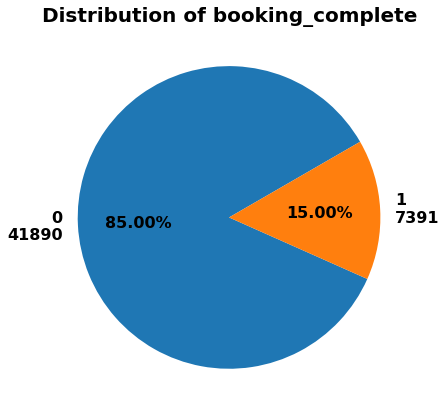

In [72]:
pieplot(df, "booking_complete")

- **Data is imbalanced because of Traget Variable.**

### sales_channel

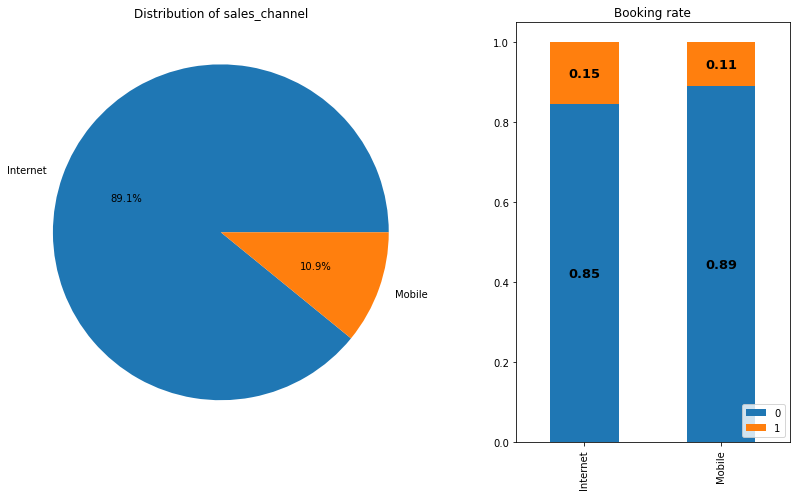

In [73]:
pie_stacked(df, "sales_channel", figsize = (12,7), ratio = [2,1])

In [74]:
df["sales_channel"] = df["sales_channel"].map({"Internet":1, "Mobile":0})

In [75]:
df["sales_channel"].value_counts()

1    43917
0     5364
Name: sales_channel, dtype: int64

- **Internet is a more preferred choice of users for looking the trip details.**
- **Internet is also more probable choice for completing booking as compare to Mobile.**

### trip_type

In [76]:
df["trip_type"].value_counts()

RoundTrip     48779
OneWay          386
CircleTrip      116
Name: trip_type, dtype: int64

In [77]:
df["trip_type"][df["trip_type"]=="CircleTrip"] = "RoundTrip"

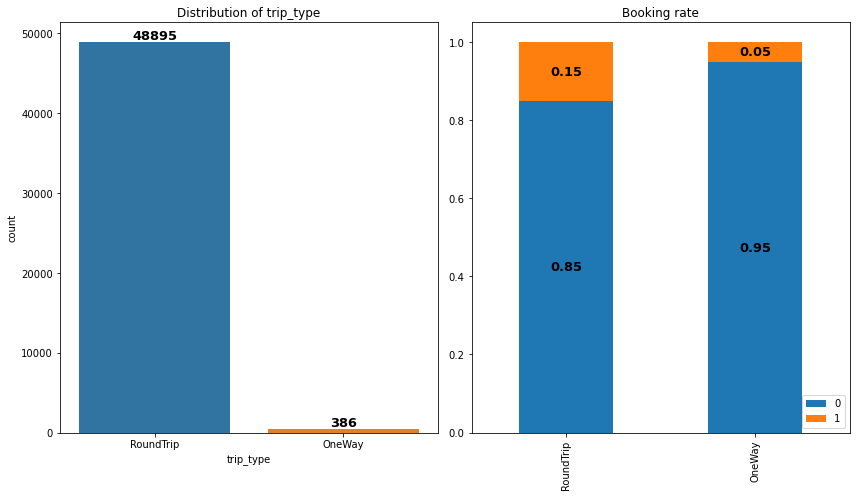

In [78]:
count_stacked(df, "trip_type",figsize = (12,7))

In [79]:
df["trip_type"] =  df["trip_type"].map({"RoundTrip":1, "OneWay":0})

In [80]:
df["trip_type"].value_counts(normalize = True)

1    0.992167
0    0.007833
Name: trip_type, dtype: float64

In [81]:
# we can drop this because all are of Rountrip and it wont help more in predicting modeling.

df.drop("trip_type", axis=1 , inplace = True)

- **People prefers round trip and they also complete the booking way more as compared to One Way.**

### wants_extra_baggage

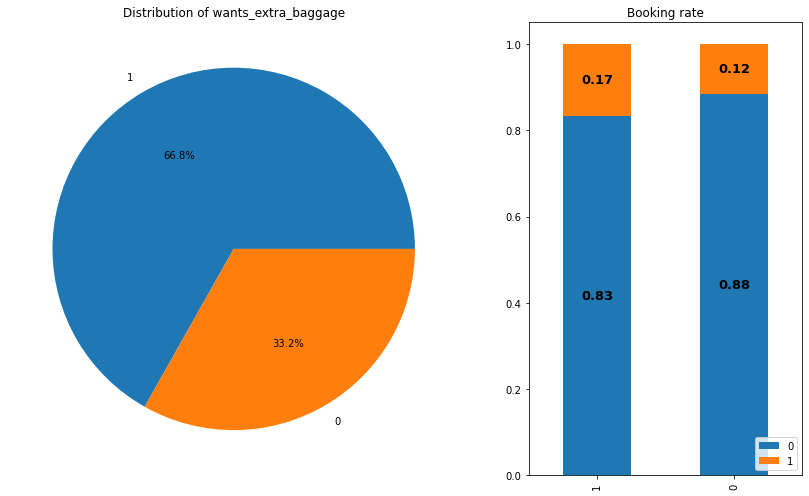

In [82]:
pie_stacked(df, "wants_extra_baggage", figsize = (12,7), ratio = [2,1])

- **People usually requests more for extra baggage and the chances of these people completing booking are higher as compared to the people who don't ask for extra baggage.**

### wants_preferred_seat    

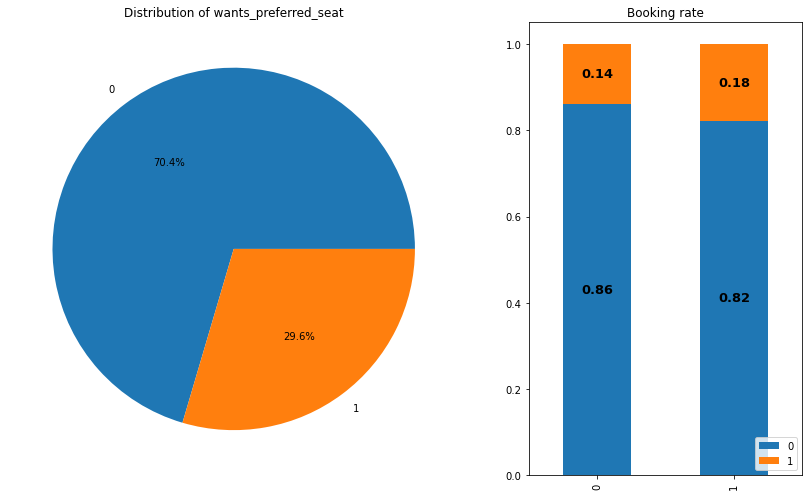

In [83]:
pie_stacked(df, "wants_preferred_seat",figsize = (12,7), ratio = [2,1])

- **There are less people who have enquired specifically for preferred seat,but the chance of completeion of booking is higher as compared to who dosent.**

### wants_in_flight_meals

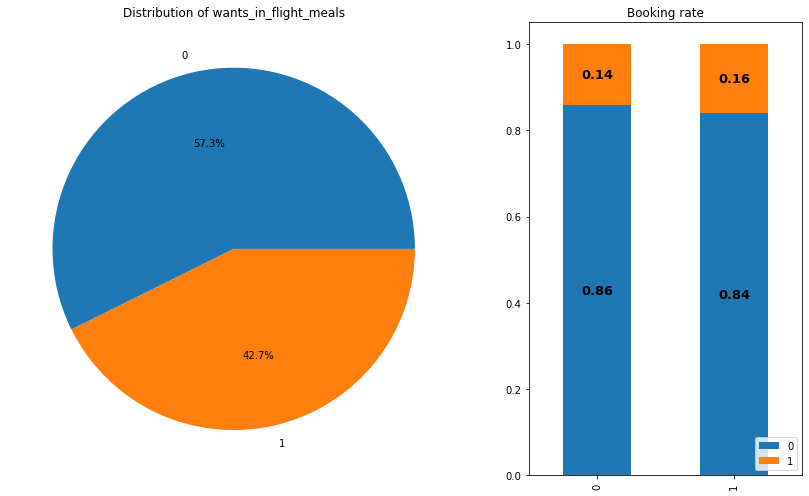

In [84]:
pie_stacked(df, "wants_in_flight_meals",figsize = (12,7), ratio = [2,1])

- **People who are interested in flight meals have more chance of completing the booking than to the people who don't want it.**

### num_passengers

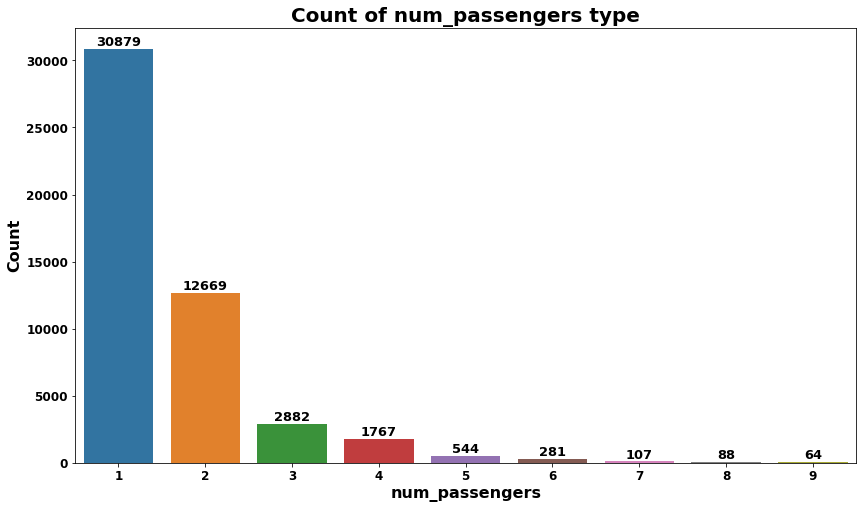

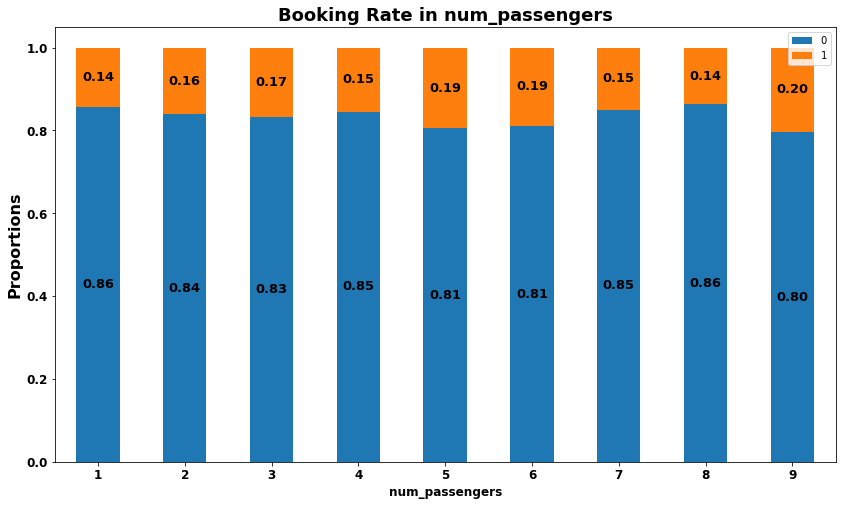

In [85]:
count_plot(df,"num_passengers", fig_size= (14,8))
stacked_barchart(df, col="num_passengers", fig_size = (14,8))

- **More the number of possengers is, higher the chance of completion of booking.**

### flight_day

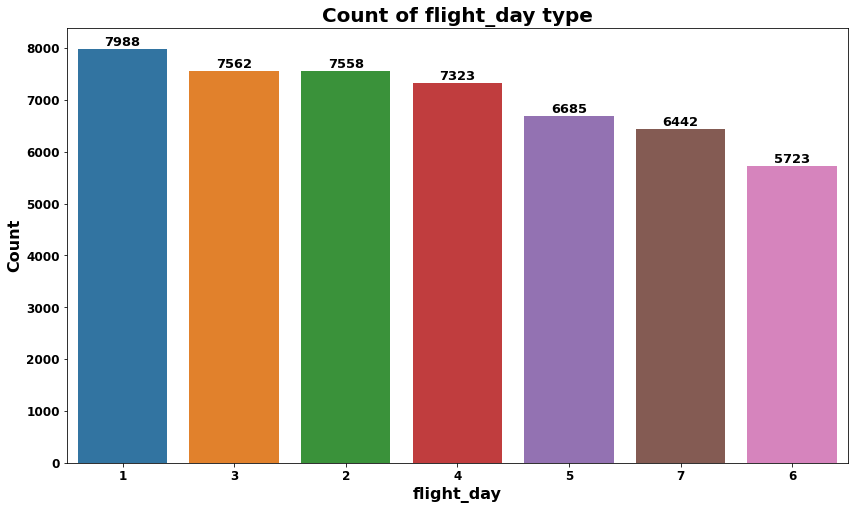

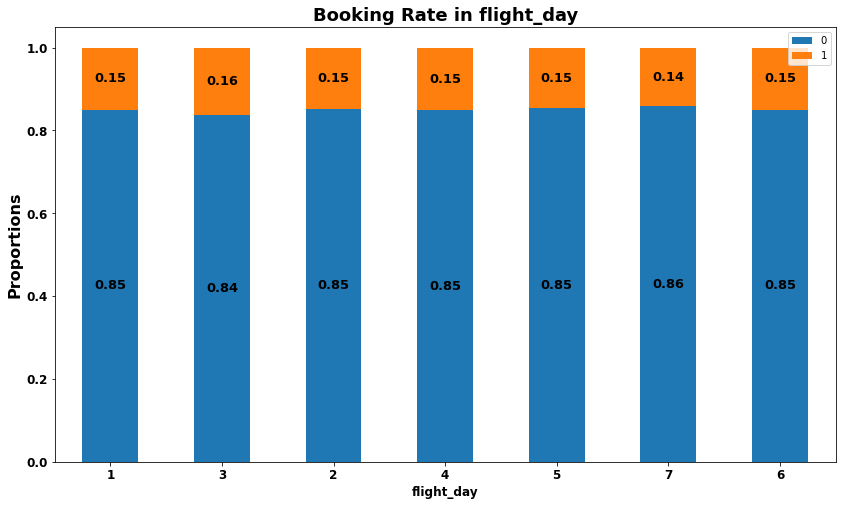

In [86]:
mappings = {"Mon":1, "Tue":2, "Wed":3, "Thu":4,"Fri":5, "Sat":6, "Sun":7 }
df["flight_day"] = df["flight_day"].map(mappings)


count_plot(df,"flight_day", fig_size= (14,8))
stacked_barchart(df, col="flight_day", fig_size = (14,8))

- **All flights looks to have same chance of booking, yet wedesday and monday have good chance as compared to other days, Since they are higher in number and probability.**


### Purchase Lead

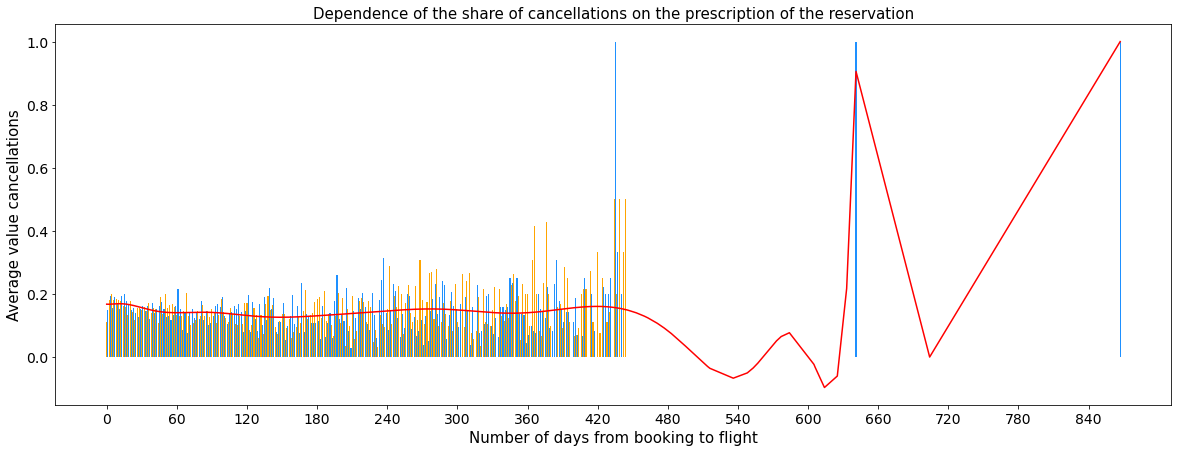

In [87]:
stat = df.groupby(['purchase_lead'], as_index=False).agg({'booking_complete': 'mean'})

fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['purchase_lead'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Number of days from booking to flight', fontsize = 15)
ax.set_xticks(np.arange(0, 900,60))
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on the prescription of the reservation', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit (stat['purchase_lead'], stat['booking_complete'], 23)
p = np.poly1d (z)
ax.plot(stat['purchase_lead'], p(stat['purchase_lead']), color='red');

### There seems to have some outliers

In [88]:
df["purchase_lead"].describe()

count    49281.000000
mean        84.723281
std         90.410229
min          0.000000
25%         21.000000
50%         51.000000
75%        115.000000
max        867.000000
Name: purchase_lead, dtype: float64

In [89]:
def check_outliers(data,threshold = 3.5):
    threshold = threshold
    outlier = []
    avg = np.mean(data)
    std = np.std(data)
    for i in data:
        z = (i-avg)/std
        if z > threshold:
            outlier.append(i)

    return outlier

In [90]:
min(check_outliers(df["purchase_lead"]))

402

In [91]:
### how many instances of purchase lead are capped where target variable is 1.
df["booking_complete"][df["purchase_lead"].isin(check_outliers(df["purchase_lead"]))].sum()

44

#### Capping the outliers

In [92]:
df["purchase_lead"][df["purchase_lead"]>=415] = 415

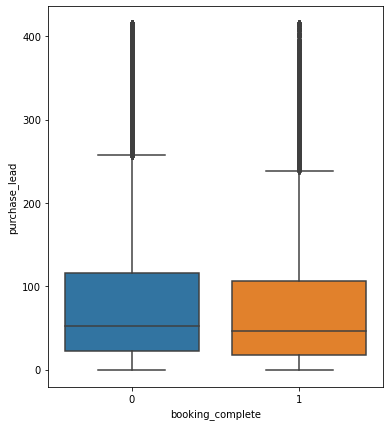

In [93]:
plt.figure(figsize = (6,7))
sns.boxplot(y=df["purchase_lead"], x= df['booking_complete'])
plt.show()

In [94]:

stat = df.groupby(['purchase_lead'], as_index=False).agg({'booking_complete': 'mean'})

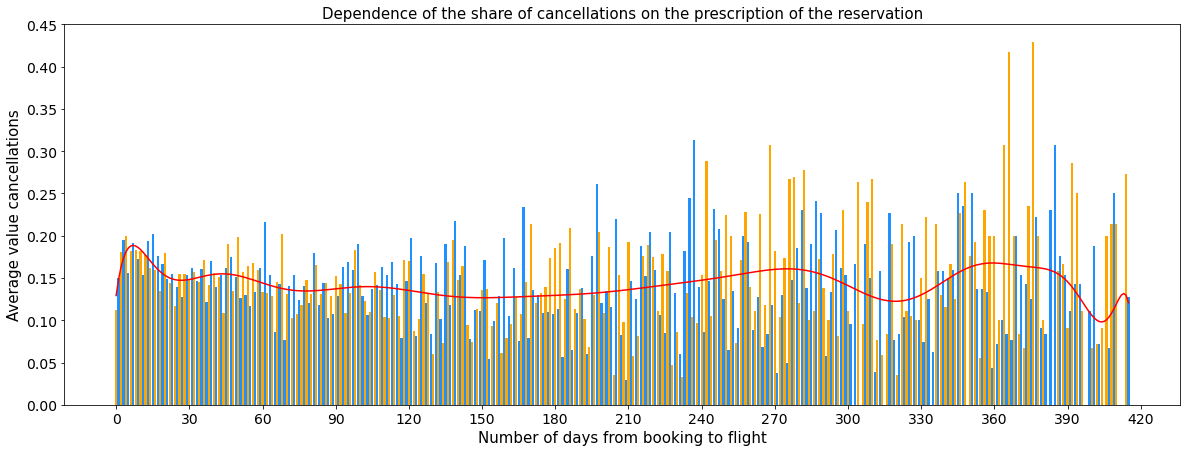

In [95]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['purchase_lead'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Number of days from booking to flight', fontsize = 15)
ax.set_xticks(np.arange(0,460 ,30))
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on the prescription of the reservation', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit (stat['purchase_lead'], stat['booking_complete'], 23)
p = np.poly1d (z)
ax.plot(stat['purchase_lead'], p(stat['purchase_lead']), color='red');

##### Converting days into months

In [96]:
df['purchase_lead_months'] = df['purchase_lead'].apply(lambda x: int(round(x / 30.5, 0)))

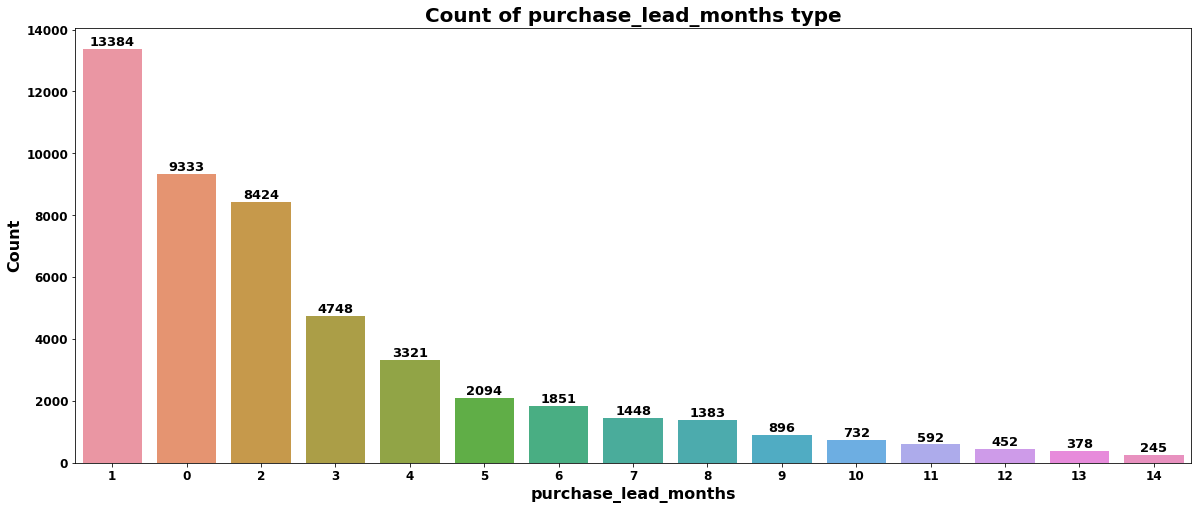

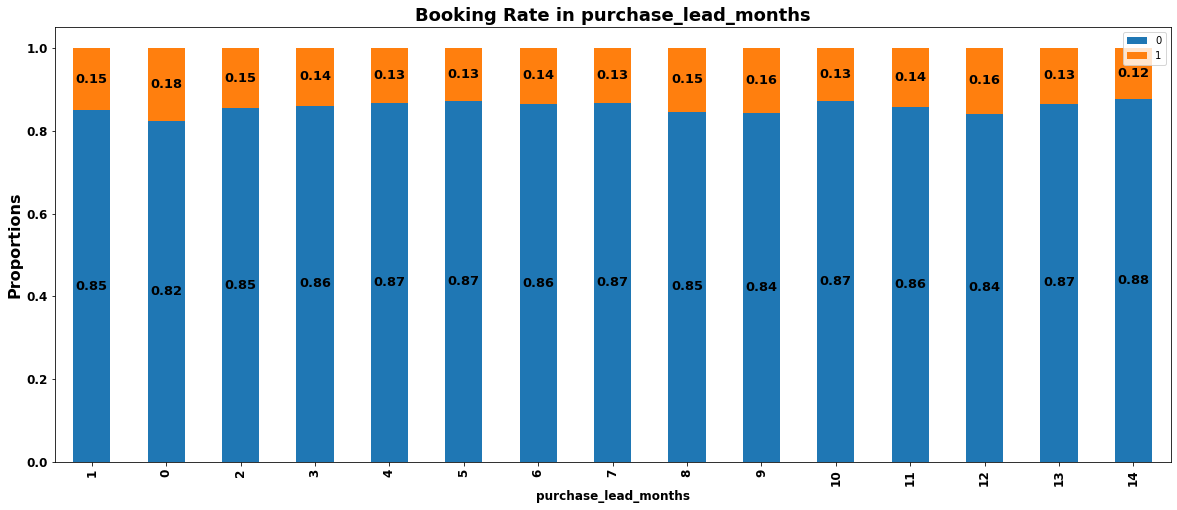

In [97]:
count_plot(df,"purchase_lead_months", fig_size= (20,8))
stacked_barchart(df, col="purchase_lead_months", fig_size = (20,8), rotation_ = 90)

In [98]:
df.drop("purchase_lead", axis=1, inplace = True)

- **People are more probable to book flights if the number of days to board flight is less than 30 days.**

### length_of_stay

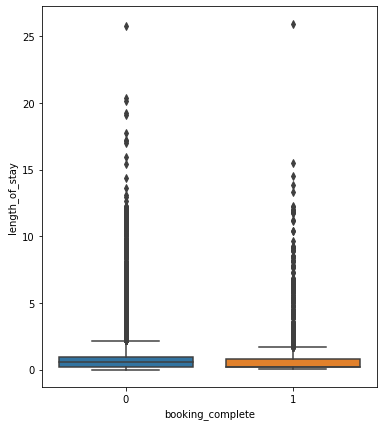

In [109]:
plt.figure(figsize = (6,7))
sns.boxplot(y=df["length_of_stay"]/30, x= df['booking_complete'])
plt.show()

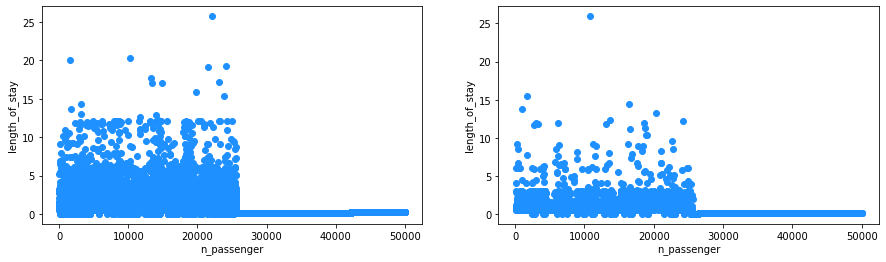

In [118]:
import matplotlib.pyplot as plt

df2 = df[df["booking_complete"] != 1]
df3 = df[df["booking_complete"] == 1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax1.scatter(df2.index, df2["length_of_stay"] / 30, c='dodgerblue')
ax1.set_xlabel('n_passenger')
ax1.set_ylabel("length_of_stay")

ax2.scatter(df3.index, df3["length_of_stay"] / 30, c='dodgerblue')
ax2.set_xlabel('n_passenger')
ax2.set_ylabel("length_of_stay")

plt.show()


In [129]:
min(check_outliers( (df2["length_of_stay"]).astype(int), threshold=5))

193

In [613]:
len(check_outliers(df["length_of_stay"]))

666

In [614]:
### how many instances of purchase lead are capped where target variable is 1.
df["booking_complete"][df["length_of_stay"].isin(check_outliers(df["length_of_stay"]))].sum()

92

In [615]:
# better map it

In [616]:
def map_months(x):
    if x>=0 and x<=10:
        return "0-10 days"
    elif x>=11 and x<=30:
        return "11-30 days"
    elif x>=31 and x<=92:
        return "1-3 months"
    elif x>=93 and x<=183:
        return "3-6 months"
    else:
        return "more than 6 months"


In [617]:
df["length_stay_bins"] = df["length_of_stay"].apply(map_months)

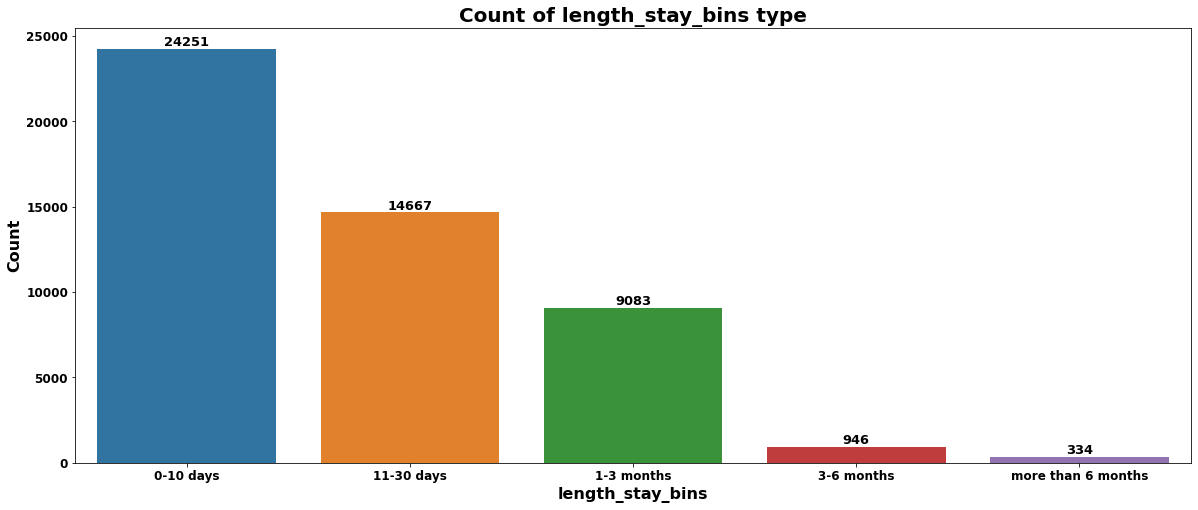

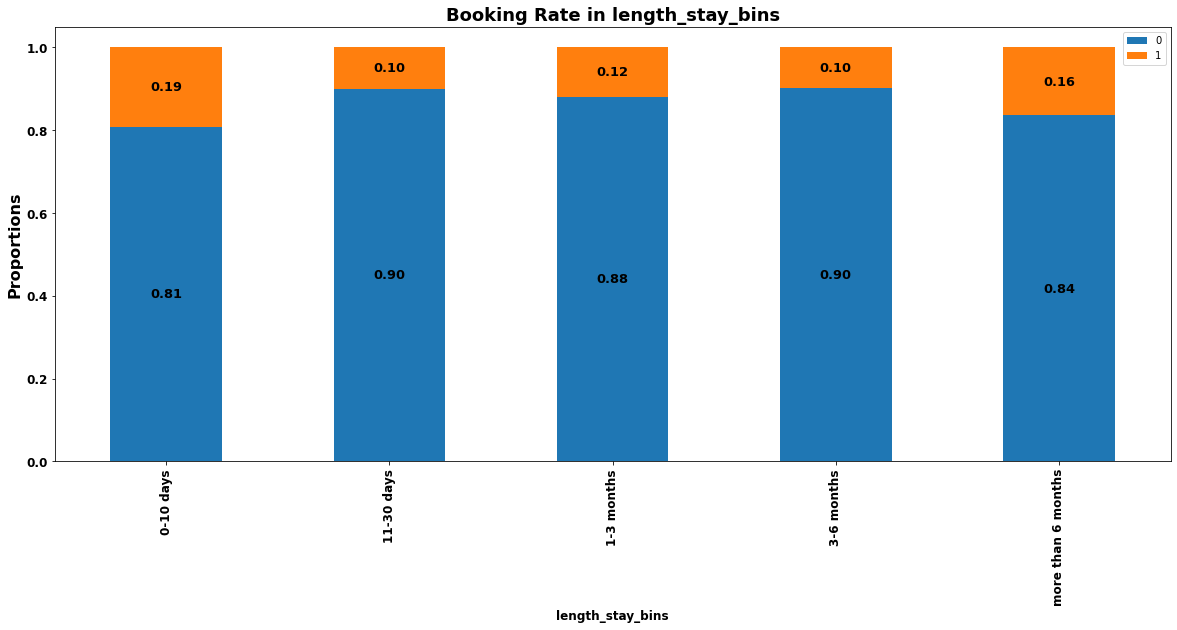

In [618]:
count_plot(df,"length_stay_bins", fig_size= (20,8))
stacked_barchart(df, col="length_stay_bins", fig_size = (20,8), rotation_ = 90)

In [619]:
df.drop(["length_of_stay"] , axis=1, inplace = True)

### flight_hour

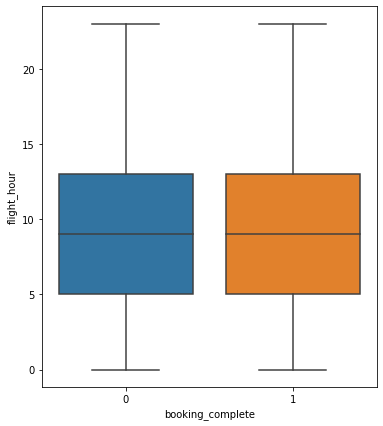

In [620]:
plt.figure(figsize = (6,7))
sns.boxplot(y=df["flight_hour"], x= df['booking_complete'])
plt.show()

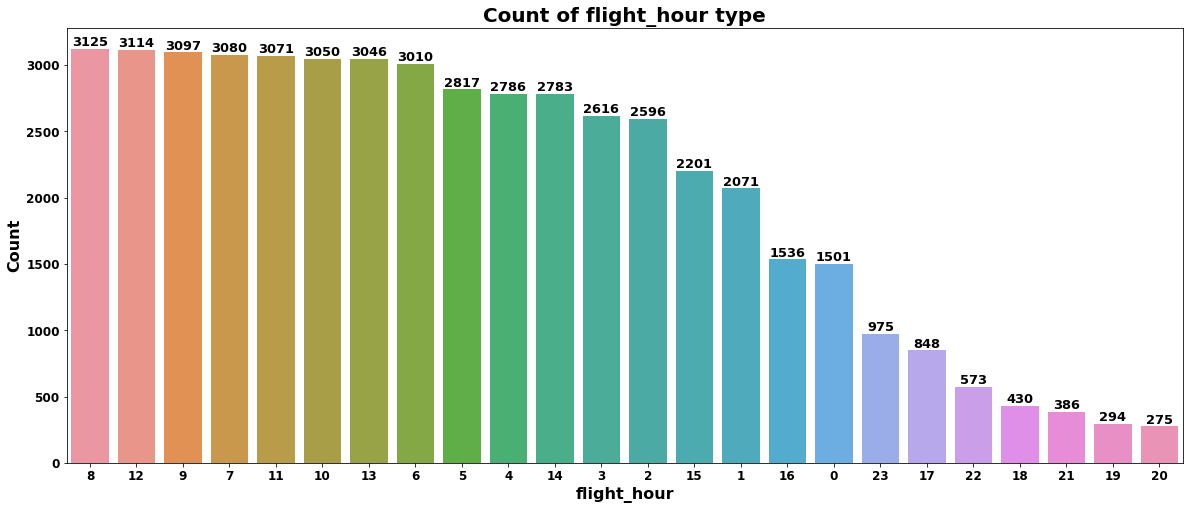

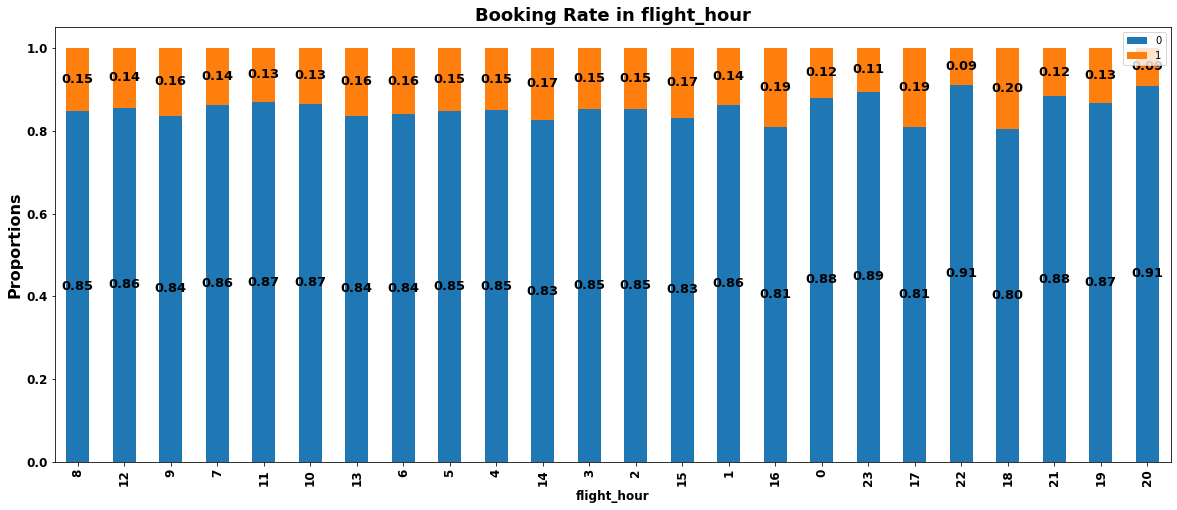

In [621]:
count_plot(df,"flight_hour", fig_size= (20,8))
stacked_barchart(df, col="flight_hour", fig_size = (20,8), rotation_ = 90)

- **People enquired more for morning hour flights ranging from late night 12 am to late afternoon till 3 pm.**
- **People who enquired for 16 hours 18 hours are more probable to book flight and least probable at 20 and 22 hour**

### booking_origin

In [622]:
df["booking_origin"].value_counts()[:20]

Australia         17691
Malaysia           7055
South Korea        4502
Japan              3819
China              3284
Indonesia          2317
Taiwan             2042
Thailand           1993
India              1258
New Zealand        1060
Singapore          1034
United States       453
Vietnam             386
Macau               301
Hong Kong           294
Philippines         265
United Kingdom      173
Brunei              161
Cambodia            131
(not set)            78
Name: booking_origin, dtype: int64

In [623]:
# top 20 booking origin
round((df["booking_origin"].value_counts()[:19].sum()/len(df))*(100),2)

97.85

In [624]:
# Around 98% OF Total instances has booking origin for these 19 countries. Hence better map it into others.

In [625]:
contin = pd.read_excel("continents.xlsx")

In [626]:
df_new = pd.merge(df, contin, on='booking_origin', how='left')

In [627]:
df_new["REGION"].fillna("Others", inplace=True)

In [628]:
df_new["REGION"].value_counts()

Australia and New Zealand          18751
South-eastern Asia                 13421
Eastern Asia                        9748
Latin America and the Caribbean     4554
Southern Asia                       1430
Northern America                     510
Northern Europe                      214
Western Europe                       190
Southern Europe                      104
Western Asia                          89
Not Available                         78
Eastern Europe                        63
Others                                54
Sub-Saharan Africa                    48
Melanesia                             10
Northern Africa                        4
Central Asia                           3
Southern Africa                        3
Central America                        2
Micronesia                             2
Polynesia                              1
Oceania                                1
Western Africa                         1
Name: REGION, dtype: int64

In [629]:
# Keeping all those origins as "Others" whose instances are less than 50 in dataset and for whom origin is not selected.

others = df_new["REGION"].value_counts()[df_new["REGION"].value_counts()<60].index.to_list()
others = others + ["Not Available"]
others

['Others',
 'Sub-Saharan Africa',
 'Melanesia',
 'Northern Africa',
 'Central Asia',
 'Southern Africa',
 'Central America',
 'Micronesia',
 'Polynesia',
 'Oceania',
 'Western Africa',
 'Not Available']

In [630]:
df_new["REGION"] = df_new["REGION"].apply(lambda x: "Others" if x in others else x)

In [631]:
df_new["REGION"].value_counts()

Australia and New Zealand          18751
South-eastern Asia                 13421
Eastern Asia                        9748
Latin America and the Caribbean     4554
Southern Asia                       1430
Northern America                     510
Northern Europe                      214
Others                               207
Western Europe                       190
Southern Europe                      104
Western Asia                          89
Eastern Europe                        63
Name: REGION, dtype: int64

In [632]:
reset = {"REGION":"booking_region"}

df_new.rename(columns = reset, inplace=True)
df_new.drop("booking_origin", inplace = True, axis=1)

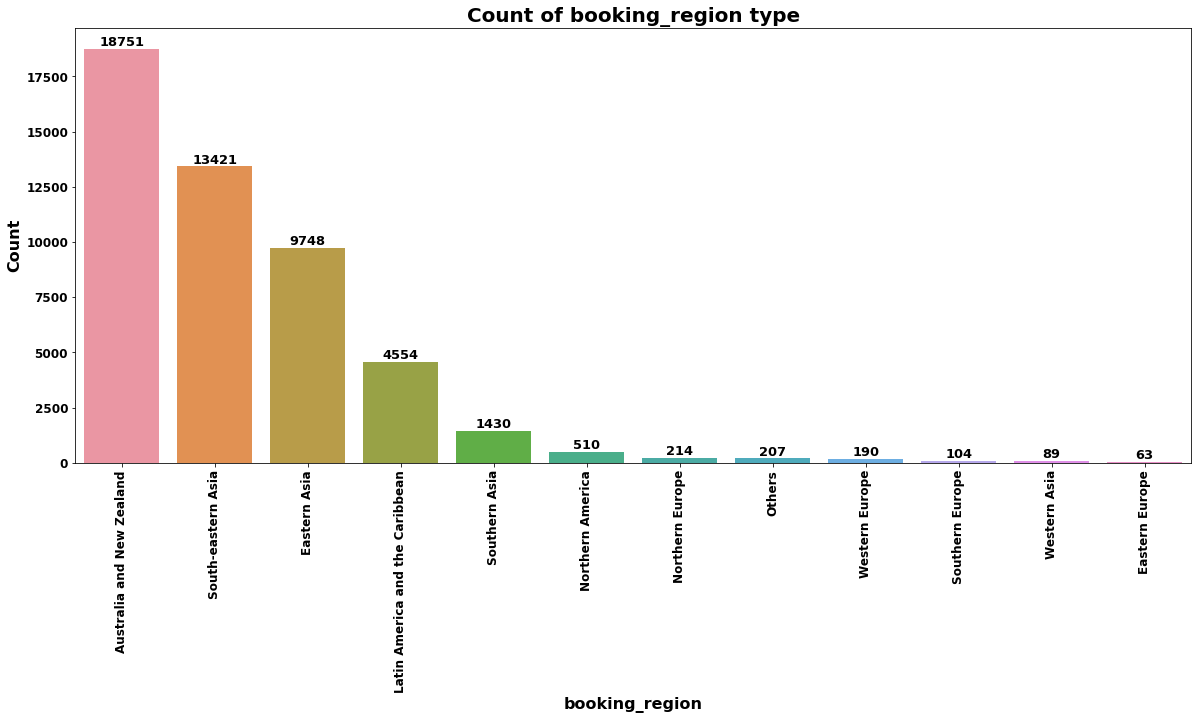

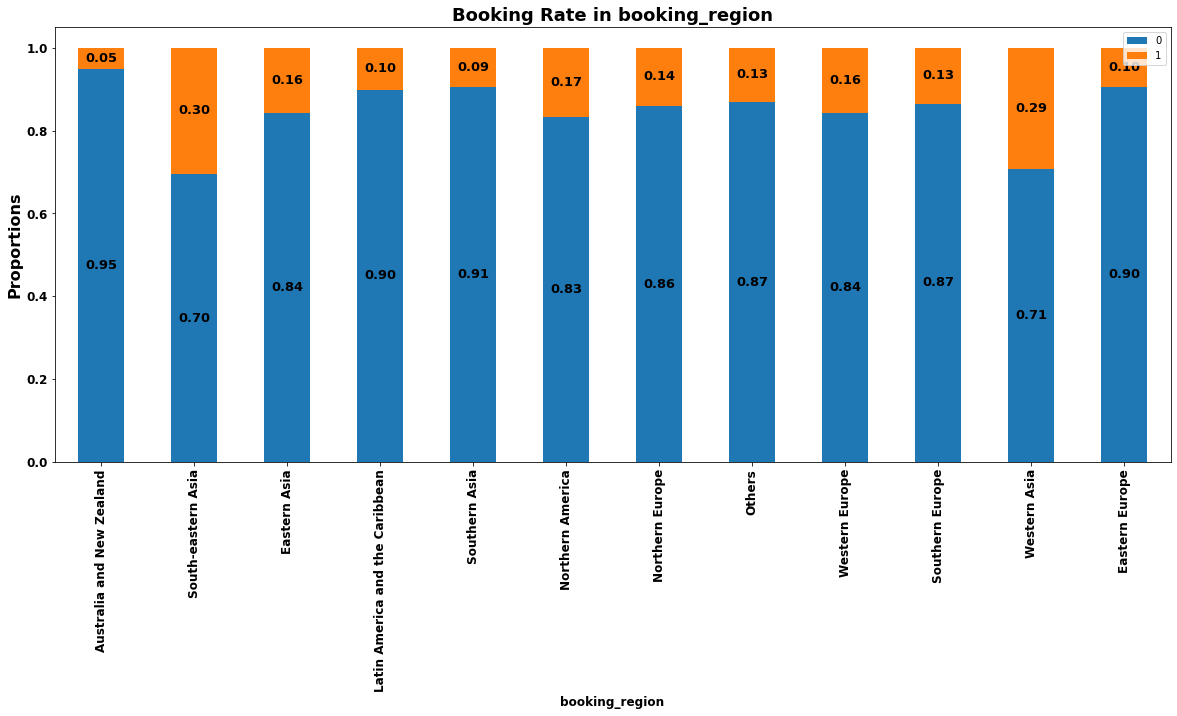

In [633]:
count_plot(df_new,"booking_region", fig_size= (20,8), rotation = 90)

stacked_barchart(df_new, col="booking_region", fig_size = (20,8), rotation_ = 90)

### flight_duration

In [634]:
df_new["flight_duration"].value_counts().sort_index()

4.67     2699
4.72      486
4.75     1246
4.83      145
5.00      237
5.07      501
5.13      116
5.33     1506
5.52      664
5.62     5464
6.33     1178
6.42     1708
6.62     4658
7.00     3314
7.42      221
7.57     2785
8.15      299
8.58     6892
8.67      787
8.83    14339
9.50       36
Name: flight_duration, dtype: int64

In [635]:
def map_flights_duration(x):
    if x<=5:
        return "4-5"
    elif x>5 and x<=6:
        return "5-6"
    elif x>6 and x<=7:
        return "6-7"
    elif x>7 and x<=8:
        return "7-8"
    else:
        return "8-9"

In [636]:
df_new["flight_duration"] = df_new["flight_duration"].apply(map_flights_duration)

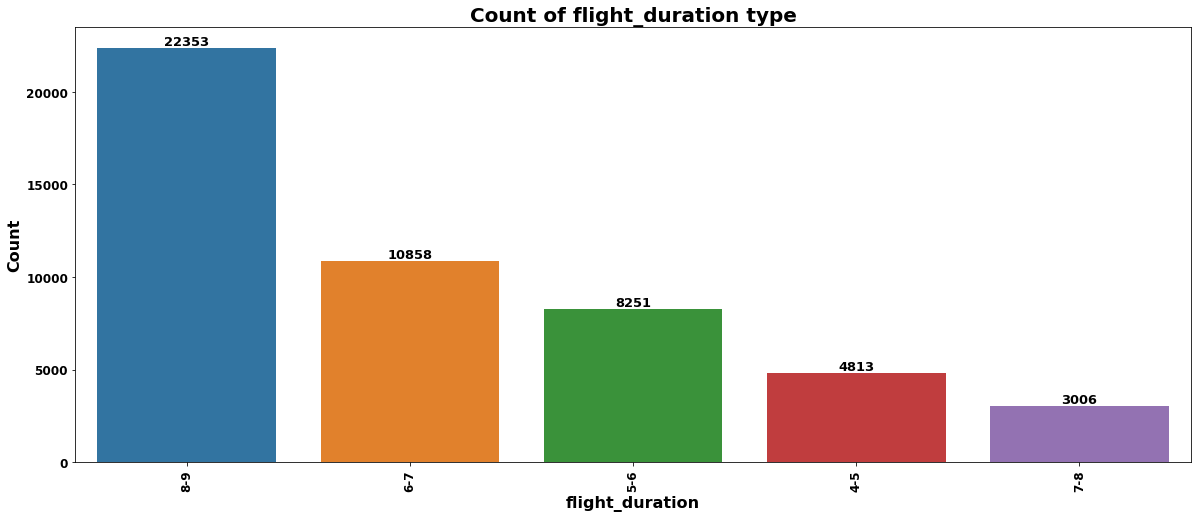

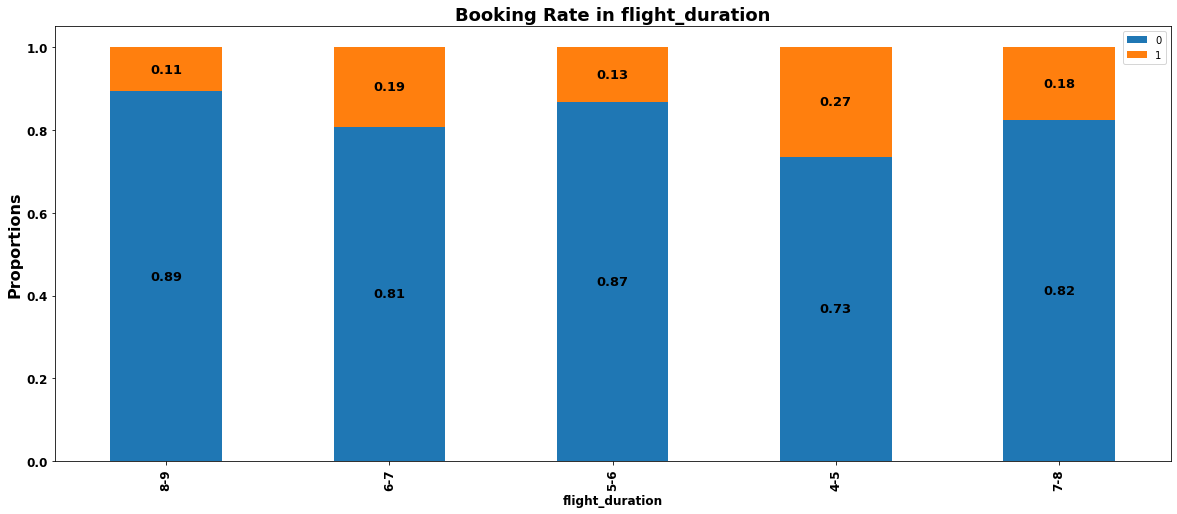

In [637]:
count_plot(df_new,"flight_duration", fig_size= (20,8), rotation = 90)
stacked_barchart(df_new, col="flight_duration", fig_size = (20,8), rotation_ = 90)

### Route

In [638]:
df_new['departure'] = df_new.route.apply(lambda x: x[:3])
df_new['arrival'] = df_new.route.apply(lambda x: x[3:])

### Departure

In [639]:
others2 = df_new["departure"].value_counts()[df_new["departure"].value_counts()<=100].index.to_list()
len(others2)-df_new["departure"].nunique()

-56

In [640]:
df_new["departure"] = df_new["departure"].apply(lambda x: "others" if x in others2 else x)

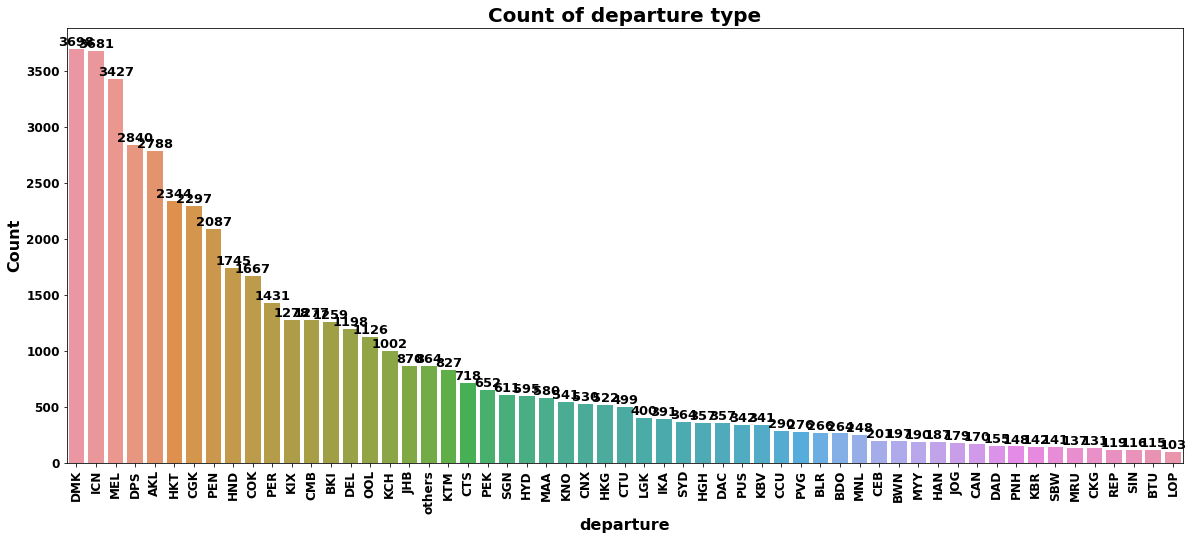

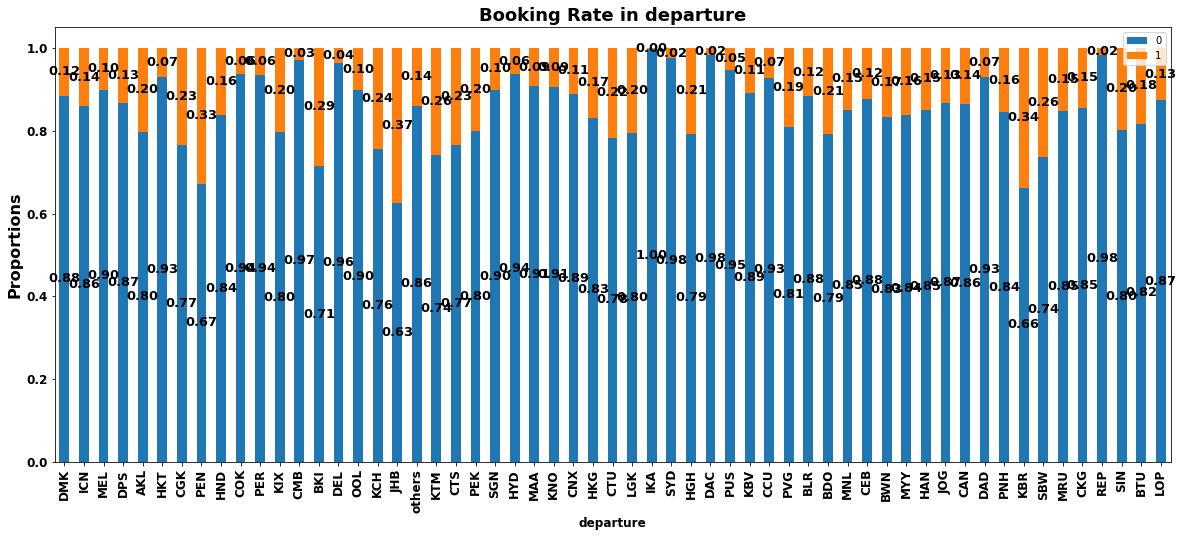

In [641]:
count_plot(df_new,"departure", fig_size= (20,8), rotation = 90)
stacked_barchart(df_new, col="departure", fig_size = (20,8), rotation_ = 90)

### Arrival

In [642]:
others2 = df_new["arrival"].value_counts()[df_new["arrival"].value_counts()<=100].index.to_list()
len(others2)-df_new["arrival"].nunique()

-43

In [643]:
df_new["arrival"] = df_new["arrival"].apply(lambda x: "others" if x in others2 else x)

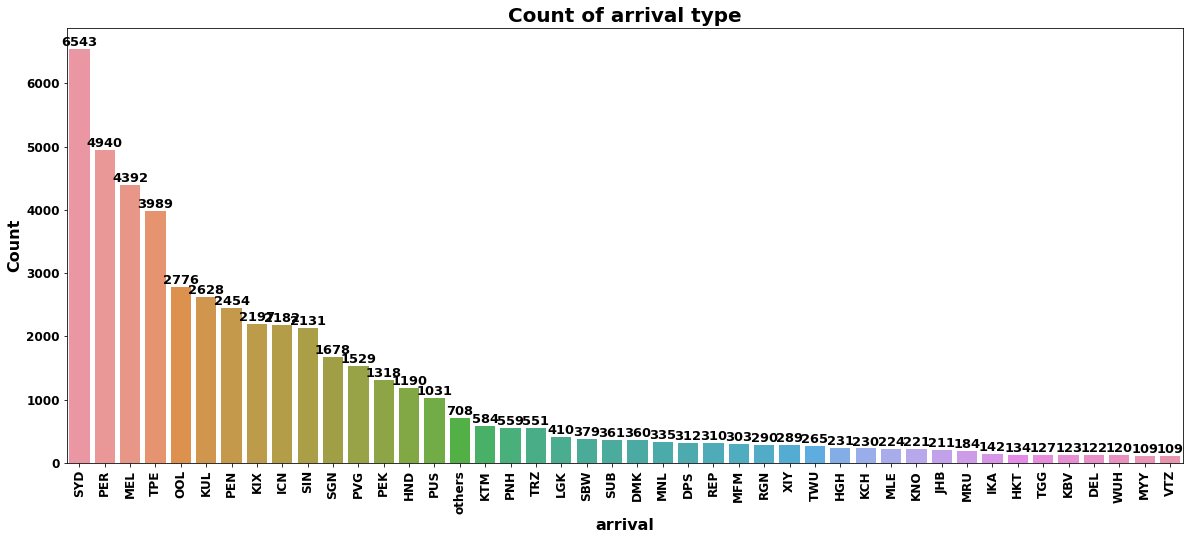

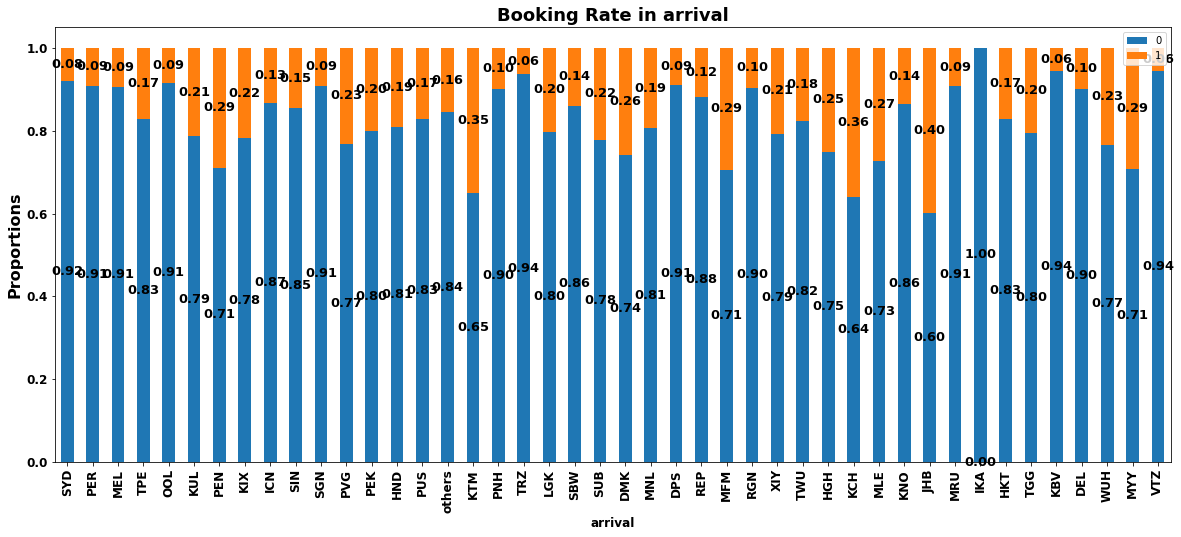

In [644]:
count_plot(df_new,"arrival", fig_size= (20,8), rotation = 90)
stacked_barchart(df_new, col="arrival", fig_size = (20,8), rotation_ = 90)

In [651]:
df_new.drop(["purchase_lead", "route"], axis=1, inplace = True)

In [652]:
df_new.shape

(49281, 15)

In [653]:
df_new.nunique()

num_passengers            9
sales_channel             2
trip_type                 2
flight_hour              24
flight_day                7
wants_extra_baggage       2
wants_preferred_seat      2
wants_in_flight_meals     2
flight_duration           5
booking_complete          2
purchase_lead1           15
length_stay_bins          5
booking_region           12
departure                57
arrival                  44
dtype: int64

In [660]:
df_new.head()


,num_passengers,sales_channel,trip_type,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,purchase_lead1,length_stay_bins,booking_region,departure,arrival
0,2,Internet,RoundTrip,7,6,1,0,0,5-6,0,9,11-30 days,Australia and New Zealand,AKL,DEL
1,1,Internet,RoundTrip,3,6,0,0,0,5-6,0,4,11-30 days,Australia and New Zealand,AKL,DEL
2,2,Internet,RoundTrip,17,3,1,1,0,5-6,0,8,11-30 days,Southern Asia,AKL,DEL
3,1,Internet,RoundTrip,4,6,0,0,1,5-6,0,3,1-3 months,Australia and New Zealand,AKL,DEL
4,2,Internet,RoundTrip,15,3,1,0,1,5-6,0,2,11-30 days,Southern Asia,AKL,DEL



## Data Preparation for modeling
##### Create Dummy variables

In [658]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49281 entries, 0 to 49280
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   num_passengers         49281 non-null  int64 
 1   sales_channel          49281 non-null  object
 2   trip_type              49281 non-null  object
 3   flight_hour            49281 non-null  int64 
 4   flight_day             49281 non-null  int64 
 5   wants_extra_baggage    49281 non-null  int64 
 6   wants_preferred_seat   49281 non-null  int64 
 7   wants_in_flight_meals  49281 non-null  int64 
 8   flight_duration        49281 non-null  object
 9   booking_complete       49281 non-null  int64 
 10  purchase_lead1         49281 non-null  int64 
 11  length_stay_bins       49281 non-null  object
 12  booking_region         49281 non-null  object
 13  departure              49281 non-null  object
 14  arrival                49281 non-null  object
dtypes: int64(8), object

In [665]:
df_new["trip_type"].value_counts()

1    48895
0      386
Name: trip_type, dtype: int64

In [666]:
df_new["sales_channel"].value_counts()

1    43917
0     5364
Name: sales_channel, dtype: int64

In [674]:
df_new.nunique().sort_values()

15

In [678]:
binary_cols = ['sales_channel', 'trip_type','wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals' ]
ordinal_cols= ['num_passengers','flight_hour','flight_day', "purchase_lead1"]
one_hot_encoding_cols = ["flight_duration", "length_stay_bins", "booking_region"]
target_encoding_cols = ["departure","arrival"]

target_var = ['booking_complete']

In [679]:
len(binary_cols + ordinal_cols + one_hot_encoding_cols + target_encoding_cols + target_var)

15

In [686]:
ordinal_cols_df = df_new[ordinal_cols]
binary_cols_df = df_new[binary_cols]

# Dummy Variables 

- Let's create dummy variables for one_hot_encoding columns

In [680]:
dummy_cols = pd.get_dummies(df_new[one_hot_encoding_cols], drop_first= True)
print(dummy_cols.shape)
dummy_cols.head()

(49281, 19)


,flight_duration_5-6,flight_duration_6-7,flight_duration_7-8,flight_duration_8-9,length_stay_bins_1-3 months,length_stay_bins_11-30 days,length_stay_bins_3-6 months,length_stay_bins_more than 6 months,booking_region_Eastern Asia,booking_region_Eastern Europe,booking_region_Latin America and the Caribbean,booking_region_Northern America,booking_region_Northern Europe,booking_region_Others,booking_region_South-eastern Asia,booking_region_Southern Asia,booking_region_Southern Europe,booking_region_Western Asia,booking_region_Western Europe
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


# Target Encoding

In [688]:
# Transforming categorical variables with TargetEncoder

from category_encoders.target_encoder import TargetEncoder

data = df_new[target_encoding_cols]
data.head()


,departure,arrival
0,AKL,DEL
1,AKL,DEL
2,AKL,DEL
3,AKL,DEL
4,AKL,DEL


In [689]:
encoder = TargetEncoder(smoothing = 0.5)

targ_encoder_df = pd.DataFrame()

for elem in data:
    targ_encoder_df[elem+'_encoding'] = encoder.fit_transform(df_new[elem], df_new['booking_complete'])

In [690]:
targ_encoder_df.head()

,departure_encoding,arrival_encoding
0,0.202296,0.098361
1,0.202296,0.098361
2,0.202296,0.098361
3,0.202296,0.098361
4,0.202296,0.098361


In [698]:
final_df = pd.concat([ordinal_cols_df,binary_cols_df, dummy_cols, targ_encoder_df, df_new[target_var]], axis=1)
final_df.head()

,num_passengers,flight_hour,flight_day,purchase_lead1,sales_channel,trip_type,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration_5-6,...,booking_region_Northern Europe,booking_region_Others,booking_region_South-eastern Asia,booking_region_Southern Asia,booking_region_Southern Europe,booking_region_Western Asia,booking_region_Western Europe,departure_encoding,arrival_encoding,booking_complete
0,2,7,6,9,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0.202296,0.098361,0
1,1,3,6,4,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0.202296,0.098361,0
2,2,17,3,8,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0.202296,0.098361,0
3,1,4,6,3,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0.202296,0.098361,0
4,2,15,3,2,1,1,1,0,1,1,...,0,0,0,1,0,0,0,0.202296,0.098361,0


In [699]:
final_df.shape

(49281, 31)

In [724]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49281 entries, 0 to 49280
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   num_passengers                                  49281 non-null  int64  
 1   flight_hour                                     49281 non-null  int64  
 2   flight_day                                      49281 non-null  int64  
 3   purchase_lead1                                  49281 non-null  int64  
 4   sales_channel                                   49281 non-null  int64  
 5   trip_type                                       49281 non-null  int64  
 6   wants_extra_baggage                             49281 non-null  int64  
 7   wants_preferred_seat                            49281 non-null  int64  
 8   wants_in_flight_meals                           49281 non-null  int64  
 9   flight_duration_5-6                    

In [733]:
categ_cols = list(set(final_df.columns.to_list()) - set(ordinal_cols) - set(targ_encoder_df.columns.to_list()) - set(target_var))
print(categ_cols)

['booking_region_Southern Europe', 'booking_region_Northern Europe', 'booking_region_Southern Asia', 'booking_region_Northern America', 'sales_channel', 'wants_preferred_seat', 'booking_region_Latin America and the Caribbean', 'booking_region_Eastern Europe', 'wants_in_flight_meals', 'length_stay_bins_3-6 months', 'length_stay_bins_more than 6 months', 'flight_duration_5-6', 'flight_duration_7-8', 'length_stay_bins_1-3 months', 'booking_region_Western Europe', 'length_stay_bins_11-30 days', 'flight_duration_8-9', 'booking_region_South-eastern Asia', 'trip_type', 'booking_region_Others', 'booking_region_Western Asia', 'booking_region_Eastern Asia', 'wants_extra_baggage', 'flight_duration_6-7']


# Correlation: Numerical Varaibles

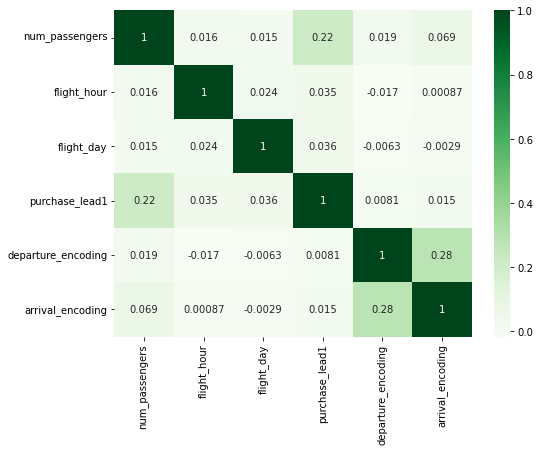

In [737]:
corr = final_df[ordinal_cols + targ_encoder_df.columns.to_list()].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot = True, cmap= "Greens")
plt.show()

# Correlation: Categorical Variable

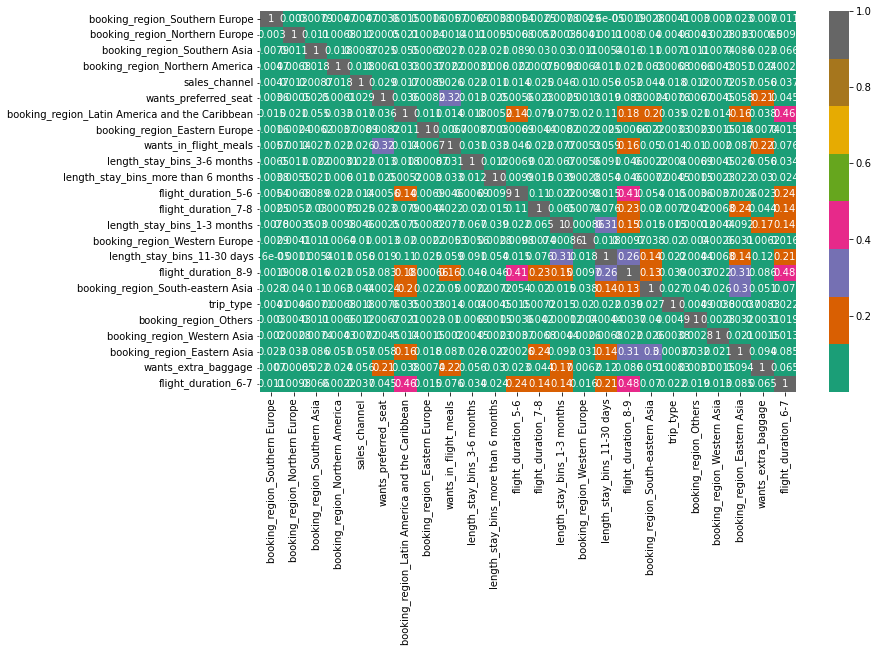

In [743]:
# Import association_metrics  
import association_metrics as am

# Convert you str columns to Category columns
categ_df = final_df[categ_cols].apply(lambda x: x.astype("category"))

# Initialize a CamresV object using your DataFrame
cramersv = am.CramersV(categ_df) 
categ_corr =  cramersv.fit()

plt.figure(figsize = (12,7))
ax = sns.heatmap(categ_corr, annot=True, cmap = "Dark2")
plt.show()

# Matmul Information

In [800]:
from sklearn.feature_selection import mutual_info_classif

X_features = final_df.drop("booking_complete",axis=1)
y_target = final_df["booking_complete"]


mi_scores = mutual_info_classif(X_features, y_target, random_state=123)

# Features with their scores
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_features.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

booking_region_South-eastern Asia                 0.030069
departure_encoding                                0.024432
arrival_encoding                                  0.018863
flight_duration_8-9                               0.013781
wants_extra_baggage                               0.011181
trip_type                                         0.009425
length_stay_bins_11-30 days                       0.007985
sales_channel                                     0.007093
wants_in_flight_meals                             0.005545
booking_region_Northern Europe                    0.003393
booking_region_Western Asia                       0.002390
flight_day                                        0.002189
wants_preferred_seat                              0.001835
purchase_lead1                                    0.001753
num_passengers                                    0.001725
flight_duration_6-7                               0.001717
length_stay_bins_more than 6 months               0.0014

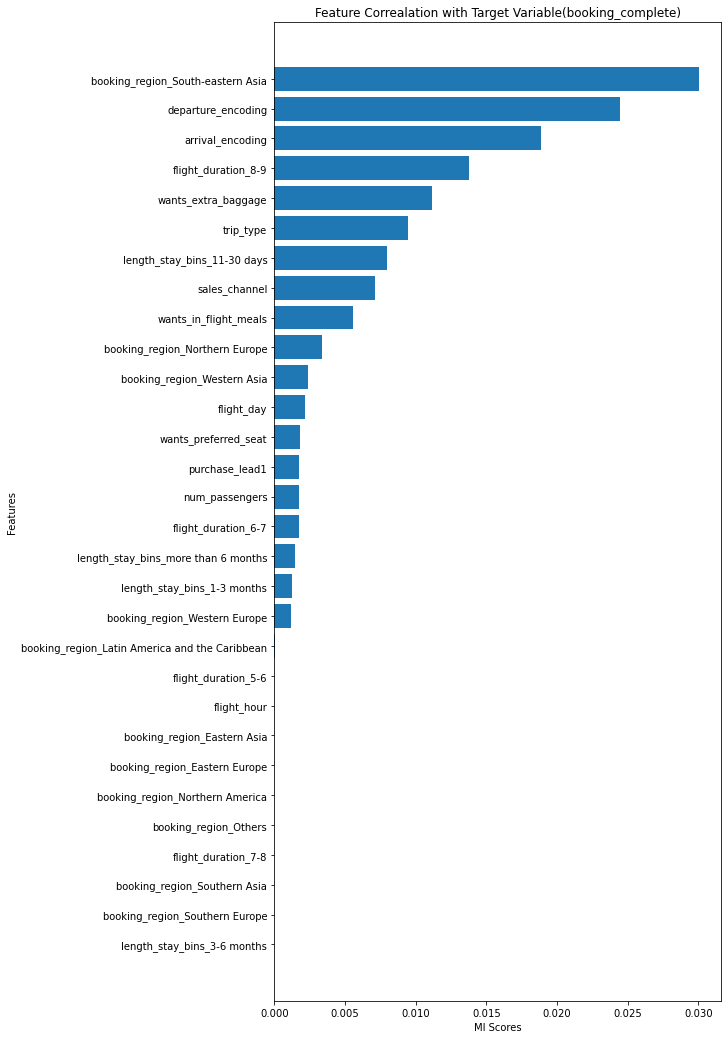

In [805]:
# plot the MI scores
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.figure(figsize=(8, 18))
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Feature Correalation with Target Variable(booking_complete)")
plt.ylabel("Features")
plt.xlabel("MI Scores")

plt.show()

# Train Test Split

In [700]:
from sklearn.model_selection import train_test_split

In [701]:
df_train, df_test = train_test_split(final_df, train_size = 0.7, test_size = 0.3, random_state = 100 )

In [702]:
print(df_train.shape)

(34496, 31)


In [703]:
print(df_test.shape)

(14785, 31)


In [704]:
df_train["booking_complete"].value_counts(normalize=True)

0    0.850678
1    0.149322
Name: booking_complete, dtype: float64

In [705]:
df_test["booking_complete"].value_counts(normalize=True)

0    0.848495
1    0.151505
Name: booking_complete, dtype: float64

In [808]:
x_train = df_train.drop("booking_complete", axis=1)
y_train = df_train["booking_complete"]

x_test = df_test.drop("booking_complete", axis=1)
y_test = df_test["booking_complete"]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (34496, 30)
y_train (34496,)
x_test (14785, 30)
y_test (14785,)


# Check of Multicollinearity for Linear Models: VIF

In [717]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor


def vif(X_train):    
    vif_df = pd.DataFrame()
    vif_df["column_name"] = X_train.columns
    vif_df["vif_values"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif_df.sort_values(by = "vif_values", ascending = False, inplace  = True)
    vif_df.reset_index( drop=True, inplace= True)
    return vif_df

In [789]:
vif(x_train)

,column_name,vif_values
0,trip_type,36.257020
1,sales_channel,8.850803
2,arrival_encoding,7.717265
3,flight_duration_8-9,6.840150
4,departure_encoding,5.761195
5,flight_day,4.617076
6,num_passengers,3.818229
7,flight_hour,3.811304
8,flight_duration_6-7,3.705495
9,wants_extra_baggage,3.589530


In [809]:
x_train = x_train.drop(["trip_type", "sales_channel"],axis=1)

# Feature Selction using: Recursive Feature Elmination

In [792]:
from sklearn.feature_selection import RFE
# Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

rfe = RFE(estimator = LogisticRegression(), n_features_to_select= 15)
rfe = rfe.fit(x_train, y_train)

In [793]:
x_train.columns[rfe.support_]

Index(['wants_extra_baggage', 'wants_preferred_seat',
       'length_stay_bins_1-3 months', 'length_stay_bins_11-30 days',
       'length_stay_bins_3-6 months', 'booking_region_Eastern Asia',
       'booking_region_Northern America', 'booking_region_Northern Europe',
       'booking_region_South-eastern Asia', 'booking_region_Southern Asia',
       'booking_region_Southern Europe', 'booking_region_Western Asia',
       'booking_region_Western Europe', 'departure_encoding',
       'arrival_encoding'],
      dtype='object')

In [810]:
x_train_prfe = x_train[x_train.columns[rfe.support_]]

vif(x_train_prfe)

,column_name,vif_values
0,arrival_encoding,5.293744
1,departure_encoding,4.394075
2,wants_extra_baggage,3.150571
3,booking_region_South-eastern Asia,2.248378
4,booking_region_Eastern Asia,1.821914
5,length_stay_bins_11-30 days,1.588963
6,wants_preferred_seat,1.451367
7,length_stay_bins_1-3 months,1.430180
8,booking_region_Southern Asia,1.049258
9,length_stay_bins_3-6 months,1.046156


# Logistic Regression

In [863]:
X_train1 = sm.add_constant(x_train)
logit1 = sm.GLM(y_train,X_train1, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm1   = logit1.fit()
glm1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34467
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12521.
Date:                Fri, 07 Jul 2023   Deviance:                       25042.
Time:                        00:26:41   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9731      0.105    -37.748      0.000      -4.179      -3.767
num_passengers                                    -0.0491      0.016     -3.067      0.002      -0.081      -0.018
flight_hour                                        0.0016      0.003      0.505      0.613      -0.004       0.008
flight_day                                        -0.0123      0.008     -1.505      0.132      -0.028       0.004
purchase_lead1                                    -0.0362      0.006     -6.447      0.000      -0.047      -0.025
wants_extra_baggage                                0.4537      0.039     11.629      0.000       0.377       0.530
wants_preferred_seat                               0.2724      0.037      7.366      0.000       0.200       0.345
wants_in_flight_meals                              0.2777      0.035      7.897      0.000       0.209       0.347
flight_duration_5-6                                0.0992      0.063      1.565      0.118      -0.025       0.223
flight_duration_6-7                                0.1321      0.058      2.286      0.022       0.019       0.245
flight_duration_7-8                               -0.0565      0.076     -0.743      0.457      -0.206       0.093
flight_duration_8-9                                0.1060      0.058      1.820      0.069      -0.008       0.220
length_stay_bins_1-3 months                       -0.6075      0.051    -11.952      0.000      -0.707      -0.508
length_stay_bins_11-30 days                       -0.3812      0.044     -8.613      0.000      -0.468      -0.294
length_stay_bins_3-6 months                       -0.8828      0.142     -6.202      0.000      -1.162      -0.604
length_stay_bins_more than 6 months               -0.0364      0.197     -0.185      0.853      -0.422       0.349
booking_region_Eastern Asia                        0.7868      0.062     12.783      0.000       0.666       0.907
booking_region_Eastern Europe                      0.3260      0.530      0.615      0.539      -0.713       1.365
booking_region_Latin America and the Caribbean     0.3521      0.082      4.298      0.000       0.192       0.513
booking_region_Northern America                    1.0426      0.150      6.964      0.000       0.749       1.336
booking_region_Northern Europe                     0.9484      0.232      4.079      0.000       0.493       1.404
booking_region_Others                              0.0817      0.321      0.255      0.799      -0.547       0.710
booking_region_South-eastern Asia                  1.4580      0.055     26.456      0.000       1.350       1.566
booking_region_Southern Asia                       0.6887      0.121      5.670      0.000   

In [865]:
X_train2 = X_train1.drop("booking_region_Others",axis=1)
logit2 = sm.GLM(y_train,X_train2, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm2   = logit2.fit()
glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34468
Model Family:                Binomial   Df Model:                           27
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12521.
Date:                Fri, 07 Jul 2023   Deviance:                       25042.
Time:                        00:27:44   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9720      0.105    -37.772      0.000      -4.178      -3.766
num_passengers                                    -0.0491      0.016     -3.066      0.002      -0.081      -0.018
flight_hour                                        0.0016      0.003      0.508      0.611      -0.004       0.008
flight_day                                        -0.0123      0.008     -1.504      0.133      -0.028       0.004
purchase_lead1                                    -0.0362      0.006     -6.450      0.000      -0.047      -0.025
wants_extra_baggage                                0.4538      0.039     11.631      0.000       0.377       0.530
wants_preferred_seat                               0.2724      0.037      7.365      0.000       0.200       0.345
wants_in_flight_meals                              0.2778      0.035      7.898      0.000       0.209       0.347
flight_duration_5-6                                0.0991      0.063      1.564      0.118      -0.025       0.223
flight_duration_6-7                                0.1321      0.058      2.287      0.022       0.019       0.245
flight_duration_7-8                               -0.0561      0.076     -0.737      0.461      -0.205       0.093
flight_duration_8-9                                0.1057      0.058      1.815      0.069      -0.008       0.220
length_stay_bins_1-3 months                       -0.6077      0.051    -11.958      0.000      -0.707      -0.508
length_stay_bins_11-30 days                       -0.3814      0.044     -8.617      0.000      -0.468      -0.295
length_stay_bins_3-6 months                       -0.8828      0.142     -6.202      0.000      -1.162      -0.604
length_stay_bins_more than 6 months               -0.0367      0.197     -0.187      0.852      -0.422       0.349
booking_region_Eastern Asia                        0.7851      0.061     12.836      0.000       0.665       0.905
booking_region_Eastern Europe                      0.3244      0.530      0.612      0.540      -0.714       1.363
booking_region_Latin America and the Caribbean     0.3504      0.082      4.292      0.000       0.190       0.510
booking_region_Northern America                    1.0410      0.150      6.960      0.000       0.748       1.334
booking_region_Northern Europe                     0.9469      0.232      4.074      0.000       0.491       1.402
booking_region_South-eastern Asia                  1.4564      0.055     26.614      0.000       1.349       1.564
booking_region_Southern Asia                       0.6873      0.121      5.664      0.000       0.449       0.925
booking_region_Southern Europe                     0.6449      0.353      1.826      0.068   

In [872]:
X_train3 = X_train2.drop("length_stay_bins_more than 6 months",axis=1)
logit3 = sm.GLM(y_train,X_train3, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm3   = logit3.fit()
glm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34469
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12521.
Date:                Fri, 07 Jul 2023   Deviance:                       25042.
Time:                        00:36:24   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9727      0.105    -37.804      0.000      -4.179      -3.767
num_passengers                                    -0.0490      0.016     -3.061      0.002      -0.080      -0.018
flight_hour                                        0.0016      0.003      0.510      0.610      -0.004       0.008
flight_day                                        -0.0123      0.008     -1.504      0.133      -0.028       0.004
purchase_lead1                                    -0.0362      0.006     -6.447      0.000      -0.047      -0.025
wants_extra_baggage                                0.4534      0.039     11.636      0.000       0.377       0.530
wants_preferred_seat                               0.2724      0.037      7.365      0.000       0.200       0.345
wants_in_flight_meals                              0.2777      0.035      7.896      0.000       0.209       0.347
flight_duration_5-6                                0.0991      0.063      1.565      0.118      -0.025       0.223
flight_duration_6-7                                0.1323      0.058      2.290      0.022       0.019       0.246
flight_duration_7-8                               -0.0559      0.076     -0.735      0.462      -0.205       0.093
flight_duration_8-9                                0.1053      0.058      1.810      0.070      -0.009       0.219
length_stay_bins_1-3 months                       -0.6070      0.051    -11.980      0.000      -0.706      -0.508
length_stay_bins_11-30 days                       -0.3806      0.044     -8.635      0.000      -0.467      -0.294
length_stay_bins_3-6 months                       -0.8820      0.142     -6.199      0.000      -1.161      -0.603
booking_region_Eastern Asia                        0.7853      0.061     12.841      0.000       0.665       0.905
booking_region_Eastern Europe                      0.3246      0.530      0.613      0.540      -0.714       1.363
booking_region_Latin America and the Caribbean     0.3503      0.082      4.290      0.000       0.190       0.510
booking_region_Northern America                    1.0413      0.150      6.962      0.000       0.748       1.334
booking_region_Northern Europe                     0.9472      0.232      4.076      0.000       0.492       1.403
booking_region_South-eastern Asia                  1.4565      0.055     26.617      0.000       1.349       1.564
booking_region_Southern Asia                       0.6868      0.121      5.661      0.000       0.449       0.925
booking_region_Southern Europe                     0.6452      0.353      1.827      0.068      -0.047       1.338
booking_region_Western Asia                        1.7667      0.290      6.099      0.000   

In [873]:
X_train4 = X_train3.drop("flight_hour",axis=1)
logit4 = sm.GLM(y_train,X_train4, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm4   = logit4.fit()
glm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34470
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12521.
Date:                Fri, 07 Jul 2023   Deviance:                       25042.
Time:                        00:37:51   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9588      0.102    -39.003      0.000      -4.158      -3.760
num_passengers                                    -0.0489      0.016     -3.054      0.002      -0.080      -0.018
flight_day                                        -0.0121      0.008     -1.486      0.137      -0.028       0.004
purchase_lead1                                    -0.0361      0.006     -6.433      0.000      -0.047      -0.025
wants_extra_baggage                                0.4533      0.039     11.632      0.000       0.377       0.530
wants_preferred_seat                               0.2726      0.037      7.372      0.000       0.200       0.345
wants_in_flight_meals                              0.2779      0.035      7.904      0.000       0.209       0.347
flight_duration_5-6                                0.0989      0.063      1.561      0.119      -0.025       0.223
flight_duration_6-7                                0.1328      0.058      2.299      0.022       0.020       0.246
flight_duration_7-8                               -0.0554      0.076     -0.728      0.466      -0.204       0.094
flight_duration_8-9                                0.1053      0.058      1.810      0.070      -0.009       0.219
length_stay_bins_1-3 months                       -0.6081      0.051    -12.013      0.000      -0.707      -0.509
length_stay_bins_11-30 days                       -0.3812      0.044     -8.652      0.000      -0.468      -0.295
length_stay_bins_3-6 months                       -0.8830      0.142     -6.206      0.000      -1.162      -0.604
booking_region_Eastern Asia                        0.7862      0.061     12.860      0.000       0.666       0.906
booking_region_Eastern Europe                      0.3264      0.530      0.616      0.538      -0.712       1.365
booking_region_Latin America and the Caribbean     0.3499      0.082      4.285      0.000       0.190       0.510
booking_region_Northern America                    1.0433      0.150      6.978      0.000       0.750       1.336
booking_region_Northern Europe                     0.9543      0.232      4.114      0.000       0.500       1.409
booking_region_South-eastern Asia                  1.4568      0.055     26.625      0.000       1.350       1.564
booking_region_Southern Asia                       0.6895      0.121      5.689      0.000       0.452       0.927
booking_region_Southern Europe                     0.6478      0.353      1.833      0.067      -0.045       1.340
booking_region_Western Asia                        1.7717      0.290      6.119      0.000       1.204       2.339
booking_region_Western Europe                      1.1658      0.235      4.951      0.000   

In [874]:
X_train5 = X_train4.drop("booking_region_Eastern Europe",axis=1)
logit5 = sm.GLM(y_train,X_train5, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm5   = logit5.fit()
glm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34471
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12521.
Date:                Fri, 07 Jul 2023   Deviance:                       25043.
Time:                        00:39:16   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9574      0.101    -39.003      0.000      -4.156      -3.759
num_passengers                                    -0.0488      0.016     -3.051      0.002      -0.080      -0.017
flight_day                                        -0.0121      0.008     -1.488      0.137      -0.028       0.004
purchase_lead1                                    -0.0361      0.006     -6.439      0.000      -0.047      -0.025
wants_extra_baggage                                0.4531      0.039     11.629      0.000       0.377       0.530
wants_preferred_seat                               0.2726      0.037      7.370      0.000       0.200       0.345
wants_in_flight_meals                              0.2777      0.035      7.899      0.000       0.209       0.347
flight_duration_5-6                                0.0988      0.063      1.558      0.119      -0.025       0.223
flight_duration_6-7                                0.1334      0.058      2.309      0.021       0.020       0.247
flight_duration_7-8                               -0.0550      0.076     -0.724      0.469      -0.204       0.094
flight_duration_8-9                                0.1052      0.058      1.808      0.071      -0.009       0.219
length_stay_bins_1-3 months                       -0.6083      0.051    -12.017      0.000      -0.708      -0.509
length_stay_bins_11-30 days                       -0.3810      0.044     -8.646      0.000      -0.467      -0.295
length_stay_bins_3-6 months                       -0.8828      0.142     -6.205      0.000      -1.162      -0.604
booking_region_Eastern Asia                        0.7840      0.061     12.849      0.000       0.664       0.904
booking_region_Latin America and the Caribbean     0.3476      0.082      4.262      0.000       0.188       0.507
booking_region_Northern America                    1.0412      0.149      6.966      0.000       0.748       1.334
booking_region_Northern Europe                     0.9524      0.232      4.106      0.000       0.498       1.407
booking_region_South-eastern Asia                  1.4547      0.055     26.648      0.000       1.348       1.562
booking_region_Southern Asia                       0.6879      0.121      5.677      0.000       0.450       0.925
booking_region_Southern Europe                     0.6458      0.353      1.828      0.068      -0.047       1.338
booking_region_Western Asia                        1.7698      0.290      6.113      0.000       1.202       2.337
booking_region_Western Europe                      1.1639      0.235      4.943      0.000       0.702       1.625
departure_encoding                                 4.2851      0.219     19.540      0.000   

In [875]:
X_train6 = X_train5.drop("flight_duration_7-8",axis=1)
logit6 = sm.GLM(y_train,X_train6, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm6   = logit6.fit()
glm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34472
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12522.
Date:                Fri, 07 Jul 2023   Deviance:                       25043.
Time:                        00:40:13   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -3.9846      0.094    -42.219      0.000      -4.170      -3.800
num_passengers                                    -0.0486      0.016     -3.038      0.002      -0.080      -0.017
flight_day                                        -0.0123      0.008     -1.505      0.132      -0.028       0.004
purchase_lead1                                    -0.0364      0.006     -6.508      0.000      -0.047      -0.025
wants_extra_baggage                                0.4538      0.039     11.651      0.000       0.377       0.530
wants_preferred_seat                               0.2708      0.037      7.339      0.000       0.198       0.343
wants_in_flight_meals                              0.2770      0.035      7.882      0.000       0.208       0.346
flight_duration_5-6                                0.1190      0.057      2.091      0.037       0.007       0.231
flight_duration_6-7                                0.1542      0.050      3.074      0.002       0.056       0.252
flight_duration_8-9                                0.1255      0.051      2.456      0.014       0.025       0.226
length_stay_bins_1-3 months                       -0.6046      0.050    -12.008      0.000      -0.703      -0.506
length_stay_bins_11-30 days                       -0.3781      0.044     -8.615      0.000      -0.464      -0.292
length_stay_bins_3-6 months                       -0.8803      0.142     -6.190      0.000      -1.159      -0.602
booking_region_Eastern Asia                        0.7816      0.061     12.828      0.000       0.662       0.901
booking_region_Latin America and the Caribbean     0.3477      0.082      4.263      0.000       0.188       0.508
booking_region_Northern America                    1.0401      0.149      6.958      0.000       0.747       1.333
booking_region_Northern Europe                     0.9519      0.232      4.104      0.000       0.497       1.406
booking_region_South-eastern Asia                  1.4538      0.055     26.642      0.000       1.347       1.561
booking_region_Southern Asia                       0.6915      0.121      5.712      0.000       0.454       0.929
booking_region_Southern Europe                     0.6464      0.353      1.830      0.067      -0.046       1.339
booking_region_Western Asia                        1.7682      0.290      6.105      0.000       1.201       2.336
booking_region_Western Europe                      1.1608      0.235      4.932      0.000       0.699       1.622
departure_encoding                                 4.3217      0.213     20.243      0.000       3.903       4.740
arrival_encoding                                   3.1728      0.242     13.095      0.000   

In [876]:
X_train7 = X_train6.drop("flight_day",axis=1)
logit7 = sm.GLM(y_train,X_train7, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm7   = logit7.fit()
glm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34473
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12523.
Date:                Fri, 07 Jul 2023   Deviance:                       25046.
Time:                        00:41:32   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1104
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -4.0303      0.089    -45.066      0.000      -4.206      -3.855
num_passengers                                    -0.0490      0.016     -3.062      0.002      -0.080      -0.018
purchase_lead1                                    -0.0367      0.006     -6.554      0.000      -0.048      -0.026
wants_extra_baggage                                0.4543      0.039     11.664      0.000       0.378       0.531
wants_preferred_seat                               0.2702      0.037      7.324      0.000       0.198       0.342
wants_in_flight_meals                              0.2767      0.035      7.875      0.000       0.208       0.346
flight_duration_5-6                                0.1195      0.057      2.099      0.036       0.008       0.231
flight_duration_6-7                                0.1543      0.050      3.077      0.002       0.056       0.253
flight_duration_8-9                                0.1248      0.051      2.443      0.015       0.025       0.225
length_stay_bins_1-3 months                       -0.6045      0.050    -12.007      0.000      -0.703      -0.506
length_stay_bins_11-30 days                       -0.3782      0.044     -8.618      0.000      -0.464      -0.292
length_stay_bins_3-6 months                       -0.8793      0.142     -6.185      0.000      -1.158      -0.601
booking_region_Eastern Asia                        0.7803      0.061     12.807      0.000       0.661       0.900
booking_region_Latin America and the Caribbean     0.3494      0.082      4.285      0.000       0.190       0.509
booking_region_Northern America                    1.0414      0.149      6.968      0.000       0.748       1.334
booking_region_Northern Europe                     0.9560      0.232      4.122      0.000       0.501       1.411
booking_region_South-eastern Asia                  1.4530      0.055     26.630      0.000       1.346       1.560
booking_region_Southern Asia                       0.6888      0.121      5.690      0.000       0.452       0.926
booking_region_Southern Europe                     0.6453      0.353      1.827      0.068      -0.047       1.338
booking_region_Western Asia                        1.7681      0.290      6.104      0.000       1.200       2.336
booking_region_Western Europe                      1.1636      0.235      4.944      0.000       0.702       1.625
departure_encoding                                 4.3254      0.213     20.263      0.000       3.907       4.744
arrival_encoding                                   3.1746      0.242     13.102      0.000       2.700       3.649
=============================================================================================

In [895]:
X_train8 = X_train7.drop("booking_region_Southern Europe",axis=1)
logit8 = sm.GLM(y_train,X_train8, family = sm.families.Binomial() ) # FAMILY IS USED FOR LINK FUNCTION BEING LOGIT )
glm8   = logit8.fit()
glm8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       booking_complete   No. Observations:                34496
Model:                            GLM   Df Residuals:                    34474
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12524.
Date:                Fri, 07 Jul 2023   Deviance:                       25048.
Time:                        00:46:12   Pearson chi2:                 3.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1104
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -4.0254      0.089    -45.050      0.000      -4.201      -3.850
num_passengers                                    -0.0489      0.016     -3.058      0.002      -0.080      -0.018
purchase_lead1                                    -0.0367      0.006     -6.557      0.000      -0.048      -0.026
wants_extra_baggage                                0.4546      0.039     11.670      0.000       0.378       0.531
wants_preferred_seat                               0.2704      0.037      7.331      0.000       0.198       0.343
wants_in_flight_meals                              0.2765      0.035      7.868      0.000       0.208       0.345
flight_duration_5-6                                0.1190      0.057      2.090      0.037       0.007       0.231
flight_duration_6-7                                0.1542      0.050      3.074      0.002       0.056       0.253
flight_duration_8-9                                0.1233      0.051      2.414      0.016       0.023       0.223
length_stay_bins_1-3 months                       -0.6050      0.050    -12.017      0.000      -0.704      -0.506
length_stay_bins_11-30 days                       -0.3789      0.044     -8.634      0.000      -0.465      -0.293
length_stay_bins_3-6 months                       -0.8792      0.142     -6.184      0.000      -1.158      -0.601
booking_region_Eastern Asia                        0.7710      0.061     12.711      0.000       0.652       0.890
booking_region_Latin America and the Caribbean     0.3409      0.081      4.188      0.000       0.181       0.500
booking_region_Northern America                    1.0330      0.149      6.915      0.000       0.740       1.326
booking_region_Northern Europe                     0.9479      0.232      4.088      0.000       0.493       1.402
booking_region_South-eastern Asia                  1.4437      0.054     26.609      0.000       1.337       1.550
booking_region_Southern Asia                       0.6821      0.121      5.639      0.000       0.445       0.919
booking_region_Western Asia                        1.7605      0.290      6.078      0.000       1.193       2.328
booking_region_Western Europe                      1.1556      0.235      4.911      0.000       0.694       1.617
departure_encoding                                 4.3369      0.213     20.323      0.000       3.919       4.755
arrival_encoding                                   3.1878      0.242     13.159      0.000       2.713       3.663
==================================================================================================================
"""

In [883]:
train_prob      = glm7.predict(X_train7)
train_pred      = train_prob.apply( lambda  x: 1 if x>0.3 else 0)

In [884]:
accuracy_score(y_train, train_pred)

0.8201530612244898

In [885]:
confusion_matrix(y_train, train_pred)

array([[26402,  2943],
       [ 3261,  1890]], dtype=int64)

In [886]:
recall_score(y_train, train_pred)

0.366919044845661

In [887]:
precision_score(y_train, train_pred)

0.39106145251396646

In [896]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=0, max_depth=None)

# Fit the model to the training data
rfc.fit(X_train8, y_train)

RandomForestClassifier(min_samples_split=100, n_estimators=1000, random_state=0)

In [890]:
y_pred = rfc.predict(X_train8)

In [891]:
print(accuracy_score(y_train, y_pred))
print(precision_score(y_train, y_pred))
print(recall_score(y_train, y_pred))

0.852707560296846
0.6861702127659575
0.025043680838672103


In [897]:


train_prob = rfc.predict_proba(X_train8)


    

In [898]:
for i in np.arange(0,1,0.05):
    train_pred = (train_prob[:, 1] > i).astype(int)
    print("\n")
    print(i)
    print(accuracy_score(y_train, train_pred))
    print(precision_score(y_train, train_pred))
    print(recall_score(y_train, train_pred))
    print("~"*50)
    print("\n")



0.0
0.14932166048237477
0.14932166048237477
1.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.05
0.41129406307977734
0.20115146496312947
0.990293146961755
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.1
0.6021857606679035
0.2627850343148107
0.9217627645117453
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.15000000000000002
0.7026611781076066
0.3126100998238403
0.8268297417977092
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.2
0.7615085807050093
0.35569525239256894
0.735973597359736
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.25
0.8097170686456401
0.40899136931598606
0.6163851679285576
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.30000000000000004
0.8410250463821892
0.4672050423478432
0.46049310813434285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.35000000000000003
0.8560702690166976
0.532202216066482
0.2983886623956513
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




0.4
0.8590561224489796
0.591862